In [ ]:
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import sys
work_path = Path(next((p for p in Path("__file__").resolve().parents if p.name == "Research"), None))
torchlib_path = str(work_path / Path("app/torch_libs"))
sys.path.append(torchlib_path)

from run_manager import RunViewer


In [ ]:
nb_path = Path().resolve()
rv = RunViewer(exp_path=nb_path)
df_base = rv.fetch_results(met_listed=False)


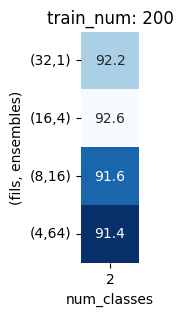

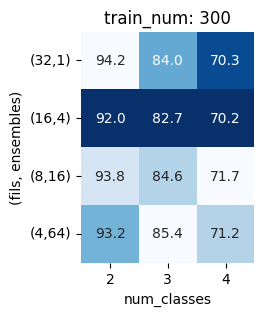

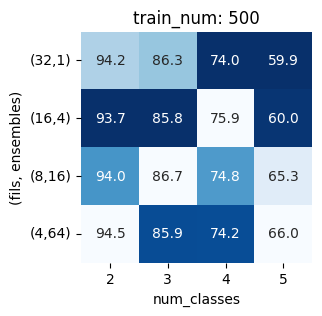

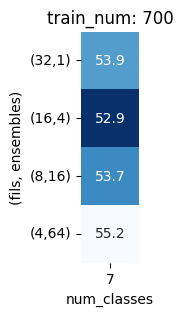

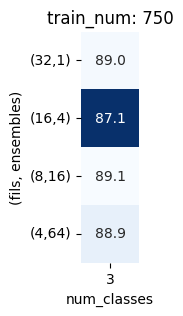

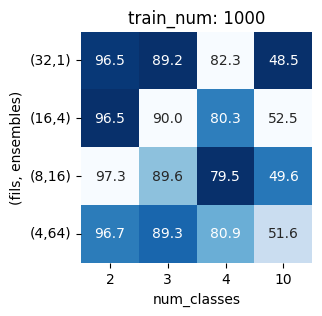

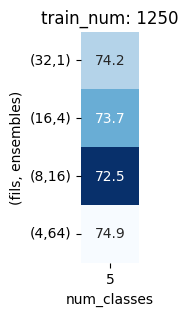

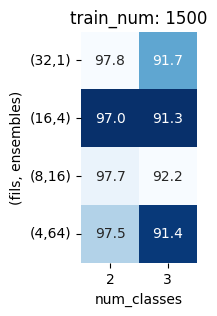

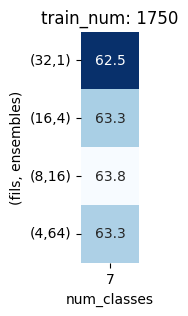

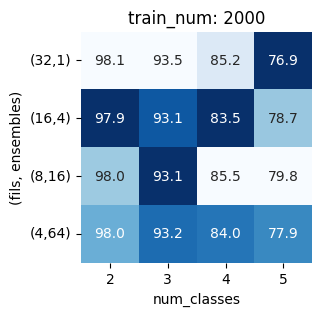

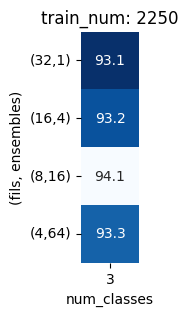

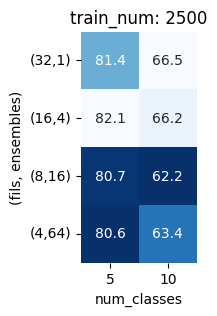

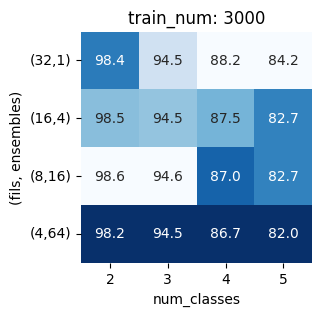

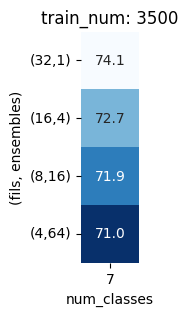

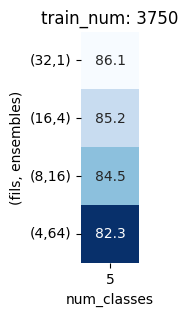

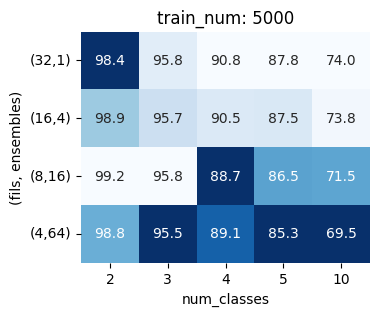

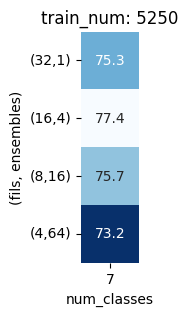

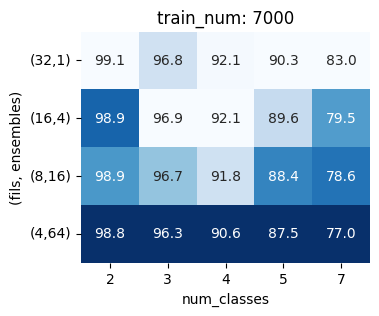

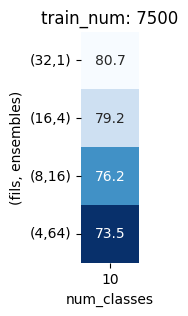

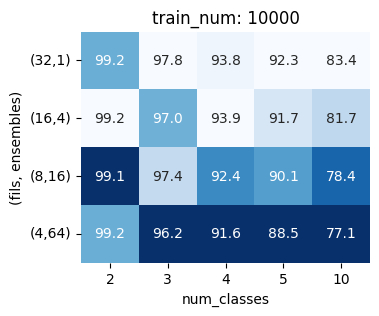

In [ ]:
df = df_base

piv_values = ["val_acc"]
piv_index = ["fils", "ensembles"]
piv_on = "num_classes"
ext_column = "train_num" # このカラムの要素ごとにheatmapを表示
# piv_on = "data_per_class"
# ext_column = "num_classes" # このカラムの要素ごとにheatmapを表示

ext_l = df[ext_column].unique()

for ext in ext_l:
    # pivot table 作成
    df_ext = df.filter(pl.col(ext_column) == ext)
    df_piv = df_ext.pivot(values=piv_values, index=piv_index, on=piv_on, sort_columns=True, aggregate_function="mean")

    # カラムが文字列順になっているため、数字部分をソート
    _num_columns = sorted(int(x) for x in df_piv.columns if x.isdigit())
    new_columns = [str(_num_columns.pop(0)) if x.isdigit() else x for x in df_piv.columns]
    df_piv = df_piv.select(new_columns)

    # (fil, ensemble) の形式に
    df_piv = df_piv.with_columns(("(" + pl.col("fils").cast(pl.Utf8) + "," + pl.col("ensembles").cast(pl.Utf8)).alias("(fils, ensembles)") + ")")
    df_piv = df_piv.select(["(fils, ensembles)"] + new_columns).select(pl.exclude(["fils", "ensembles"]))

    # 0列目がx軸ラベル、1列目以降がy軸ラベルになる df を heat map に変換
    square_size = 0.75
    hm_x = df_piv.columns[1:]
    hm_y = df_piv[df_piv.columns[0]]
    data = df_piv.select(hm_x).to_numpy()
    annot = data.copy()

    # 各行に対して min-max 正規化を適用
    axis = 0

    min_vals = data.min(axis=axis, keepdims=True)
    max_vals = data.max(axis=axis, keepdims=True)
    data = (data - min_vals) / (max_vals - min_vals + 1e-8)  # ゼロ除算対策で微小値を加える

    annot *= 100
    sp_kwargs = {}
    hm_kwargs = {"cmap": "Blues_r", "cbar": False, "fmt": ".1f"}

    # plot
    fig, ax = plt.subplots(figsize=(len(hm_x)*square_size, len(hm_y)*square_size), **sp_kwargs)
    ax = sns.heatmap(data, annot=annot, square=True, **hm_kwargs)

    # memo
    # xticklabels=pl.Series(df_piv_val.columns)
    # xticklabels=pl.Series(df_piv_val.columns).str.head(4)

    ax.set_title(f"{ext_column}: {ext}", fontsize=12)
    ax.set_xlabel(piv_on, fontsize=10)
    ax.set_ylabel(hm_y.name, fontsize=10, rotation=90)
    ax.set_xticklabels(hm_x, fontsize=10, rotation=0)
    ax.set_yticklabels(hm_y, fontsize=10, rotation=0)
    plt.show()
